In [ ]:
import cv2
import numpy as np
import os
from pdf2image import convert_from_path
from PIL import Image
from matplotlib import pyplot as plt

In [638]:
def convert_pdf_folder_to_images(pdf_folder, output_folder):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    
    for filename in os.listdir(pdf_folder):
        if filename.endswith('.pdf'):
            pdf_path = os.path.join(pdf_folder, filename)
            images = convert_from_path(pdf_path)
            base_filename = os.path.splitext(filename)[0]
            for page_num, img in enumerate(images):
                output_path = os.path.join(output_folder, f"{base_filename}_page_{page_num + 1}.jpg")
                img.save(output_path, 'JPEG')
                
                width, height = img.size
                left_half = img.crop((0, 0, width // 2, height))
                right_half = img.crop((width // 2, 0, width, height))

                left_half_path = os.path.join(output_folder, f"{base_filename}_page_{page_num + 1}_left.jpg")
                right_half_path = os.path.join(output_folder, f"{base_filename}_page_{page_num + 1}_right.jpg")
                
                left_half.save(left_half_path, 'JPEG')
                right_half.save(right_half_path, 'JPEG')
                
pdf_folder = './scan/datas/pdf'  # PDF 파일이 있는 폴더 경로
image_output_folder = './scan/datas/pdf/divided'  # 출력 이미지 파일을 저장할 폴더 경로

convert_pdf_folder_to_images(pdf_folder, image_output_folder)

In [745]:
def is_square(cnt, min_area, max_area):
    epsilon = 0.02 * cv2.arcLength(cnt, True)
    approx = cv2.approxPolyDP(cnt, epsilon, True)
    
    # 정사각형은 꼭지점이 4개여야 함
    if len(approx) != 4:
        return False

    # 각도와 비율 체크
    for i in range(4):
        pt1 = approx[i][0]
        pt2 = approx[(i + 1) % 4][0]
        pt3 = approx[(i + 2) % 4][0]
        
        vec1 = pt2 - pt1
        vec2 = pt3 - pt2
        
        dot_product = vec1[0] * vec2[0] + vec1[1] * vec2[1]
        magnitude1 = np.sqrt(vec1[0]**2 + vec1[1]**2)
        magnitude2 = np.sqrt(vec2[0]**2 + vec2[1]**2)
        
        cos_angle = dot_product / (magnitude1 * magnitude2)
        angle = np.arccos(cos_angle) * (180 / np.pi)
        
        if angle < 80 or angle > 100:  # 각도가 직각에 가까운지 체크
            return False
    
    # 가로와 세로의 길이가 거의 같은지 확인
    x, y, w, h = cv2.boundingRect(approx)
    if abs(w - h) > min(w, h) * 0.1:  # 정사각형 비율이 아닌 경우 제외
        return False
    
    area = cv2.contourArea(cnt)
    if area < min_area or area > max_area:
        return False

    return True

def draw_contours(image_folder, output_folder, min_area=100, max_area=1000):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    
    cut_dict = dict()
    for filename in os.listdir(image_folder):
        if (filename.endswith('.jpg')) and (("_left" in filename) or ("_right" in filename)):
            image_path = os.path.join(image_folder, filename)
            img = cv2.imread(image_path)
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            blurred = cv2.GaussianBlur(gray, (9, 9), 0)

            # 경계 검출 (Canny Edge Detection)
            edges = cv2.Canny(blurred, 50, 100) # 50 100

            # 윤곽선 검출
            contours, _ = cv2.findContours(edges.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

            # 사각형 및 크기 필터링
            rectangles = [cnt for cnt in contours if is_square(cnt, min_area, max_area)]
            rectangles = rectangles[:2] + rectangles[-2:]
            # 원본 이미지에 윤곽선 그리기
            # x 좌표와 y 좌표가 가장 작은 점이 좌상단 (top-left).
            # x 좌표는 크지만 y 좌표가 작은 점이 우상단 (top-right).
            # x 좌표는 작지만 y 좌표가 큰 점이 좌하단 (bottom-left).
            # x 좌표와 y 좌표가 모두 큰 점이 우하단 (bottom-right).
            cut_xy = []
            for rdx, rect in enumerate(rectangles):
                x, y, w, h = cv2.boundingRect(rect)
                if rdx == 0: # 우하단
                    cut_xy += [x + w]
                    cut_xy += [y + h]
                if rdx == 3: # 좌상단
                    cut_xy = [x, y] + cut_xy
                # cv2.rectangle(img, (x, y), (x + w, y + h), (0, 0, 255), 5)
            cut_xy = tuple(cut_xy)
            img = img[cut_xy[1]:cut_xy[3], cut_xy[0]:cut_xy[2]]
            
            # 결과 이미지 저장
            result_image_path = os.path.join(output_folder, f"square_{filename}")
            cv2.imwrite(result_image_path, img)
            # cropped_image.save(result_image_path)
            cut_dict.update({filename:cut_xy})
            
    return

# 사용 예시
image_output_folder = './scan/datas/pdf/divided'
contour_output_folder = './scan/datas/pdf/square'  # 네모를 기준으로 자른 사진을 저장할 폴더 경로

# 이미지에서 윤곽선 검출 및 그리기
draw_contours(image_output_folder, contour_output_folder)

In [763]:
# 사용자 정의 원문자 영역 
rects_point_dict = dict()

rects_point_dict["square_FIT_page_1_left.jpg"] = [[247, 139, 398, 1189], [629, 96, 781, 1180], [1013, 140, 1160, 1190], [1390, 130, 1543, 1004], [1199, 1404, 1323, 1603], [1358, 1407, 1485, 1597], [606, 1763, 781, 2097], [1368, 1761, 1553, 2100]]
rects_point_dict["square_FIT_page_1_right.jpg"] = [[290, 522, 653, 572], [290, 746, 359, 940], [363, 745, 510, 1096], [518, 743, 648, 1099], [674, 357, 888, 1096], [896, 357, 1102, 1095], [1114, 360, 1320, 1096], [1330, 361, 1539, 1095], [604, 1269, 781, 2192], [1369, 1264, 1545, 2186]]
rects_point_dict["square_FIT_page_2_left.jpg"] = [[602, 138, 782, 2188], [1368, 134, 1543, 2186]]
rects_point_dict["square_FIT_page_2_right.jpg"] = [[602, 137, 780, 904], [1371, 139, 1546, 856], [242, 1070, 398, 2180], [625, 1072, 784, 2185], [1006, 1083, 1167, 2179], [1395, 1073, 1546, 2184]]

rects_point_dict["square_POWER_page_1_left.jpg"] = [[653, 62, 795, 1150], [1418, 59, 1554, 1092], [652, 1237, 793, 2070], [1421, 1240, 1554, 2008]]
rects_point_dict["square_POWER_page_1_right.jpg"] = [[271, 392, 642, 446], [278, 506, 635, 560], [266, 725, 350, 889], [355, 717, 484, 1071], [492, 713, 628, 1068], [662, 328, 872, 1070], [880, 328, 1088, 1068], [1092, 327, 1311, 1068], [1313, 328, 1531, 1067], [622, 1152, 765, 2182], [1376, 1154, 1532, 2187]]
rects_point_dict["square_POWER_page_2_left.jpg"] = [[652, 60, 805, 2190], [1416, 63, 1556, 2191]]
rects_point_dict["square_POWER_page_2_right.jpg"] = [[614, 57, 765, 2184], [1378, 57, 1532, 2189]]

rects_point_dict["square_POWER_page_3_left.jpg"] = [[610, 131, 804, 1098], [1388, 134, 1557, 1035], [616, 1214, 790, 2054], [1385, 1205, 1551, 1995]]
rects_point_dict["square_POWER_page_3_right.jpg"] = [[276, 671, 640, 728], [267, 884, 342, 1165], [348, 884, 489, 1234], [496, 885, 631, 1241], [655, 491, 872, 1228], [879, 489, 1094, 1233], [1100, 493, 1306, 1230], [1312, 492, 1525, 1232], [585, 1355, 773, 2161], [1362, 1359, 1536, 2164]]
rects_point_dict["square_POWER_page_4_left.jpg"] = [[617, 221, 797, 2097], [1388, 222, 1559, 2096]]
rects_point_dict["square_POWER_page_4_right.jpg"] = [[567, 214, 765, 2093], [1356, 219, 1537, 2098]]

In [781]:
def is_circle(cnt, min_radius, max_radius, filename, circle_point_dict):
    # 최소 외접 원 구하기
    (x, y), radius = cv2.minEnclosingCircle(cnt)
    radius = int(radius)
    
    if radius < min_radius or radius > max_radius:
        return False
    
    # 윤곽선의 면적과 최소 외접 원의 면적 비교
    circle_area = np.pi * (radius ** 2)
    contour_area = cv2.contourArea(cnt)
    if contour_area / circle_area < 0.8:
        return False

    # 타원 적합도 확인
    if len(cnt) >= 5:  # 타원을 적합하기 위해 최소 5개의 점이 필요
        ellipse = cv2.fitEllipse(cnt)
        (center, axes, orientation) = ellipse
        major_axis_length = max(axes)
        minor_axis_length = min(axes)
        eccentricity = np.sqrt(1 - (minor_axis_length / major_axis_length) ** 2)
        
        # 원에 가까운 정도를 확인 (이심률이 낮을수록 원에 가까움)
        if eccentricity > 0.5:  # 이심률이 0.5보다 크면 원형이 아님
            return False

    # 원의 경계 좌표
    circle_left = x - radius
    circle_top = y - radius
    circle_right = x + radius
    circle_bottom = y + radius

    # 원이 사각형 내부에 완전히 포함되는지 확인
    pass_point = False
    for rect_point in rects_point_dict[filename]:
        left, top, right, bottom = rect_point
        if (circle_left >= left and
            circle_top >= top and
            circle_right <= right and
            circle_bottom <= bottom):
            pass_point = True
            circle_point_dict[filename].append([circle_left, circle_top, circle_right, circle_bottom])
            break
    
    if not pass_point:
        return False
    
    return True


def draw_contours(image_folder, output_folder, min_radius=9, max_radius=15): # 여기는 문제 없음
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
        
    circle_point_dict = dict()
    for filename in os.listdir(image_folder):
        if (filename.endswith('.jpg')) and (("_left" in filename) or ("_right" in filename)):
            circle_point_dict[filename] = []
            
            
            image_path = os.path.join(image_folder, filename)
            img = cv2.imread(image_path)
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            blurred = cv2.GaussianBlur(gray, (9, 9), 0)

            # 경계 검출 (Canny Edge Detection)
            edges = cv2.Canny(blurred, 50, 100) # 50 100

            # 윤곽선 검출
            contours, _ = cv2.findContours(edges.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            # 원형 및 크기 필터링
            large_contours = [cnt for cnt in contours if is_circle(cnt, min_radius, max_radius, filename, circle_point_dict)]

            # 원본 이미지에 윤곽선 그리기
            cv2.drawContours(img, large_contours, -1, (255, 0, 0), 2)

            # if filename == 'square_FIT_page_2_right.jpg':
            #     for cnt in new_points:
            #         cv2.circle(img, cnt, 3, (0, 0, 255), -1)  # 중심에 파란색 점 그리기
                    
            # 결과 이미지 저장
            result_image_path = os.path.join(output_folder, f"circles_{filename}")
            cv2.imwrite(result_image_path, img)
    return circle_point_dict

image_output_folder = './scan/datas/pdf/square' 
contour_output_folder = './scan/datas/pdf/circles'  # 동그라미 검출 이미지를 저장할 폴더 경로

# 이미지에서 윤곽선 검출 및 그리기
circle_point_dict = draw_contours(image_output_folder, contour_output_folder)


---

x+y가 가장 큰 key: 0
x+y가 가장 작은 key: 19


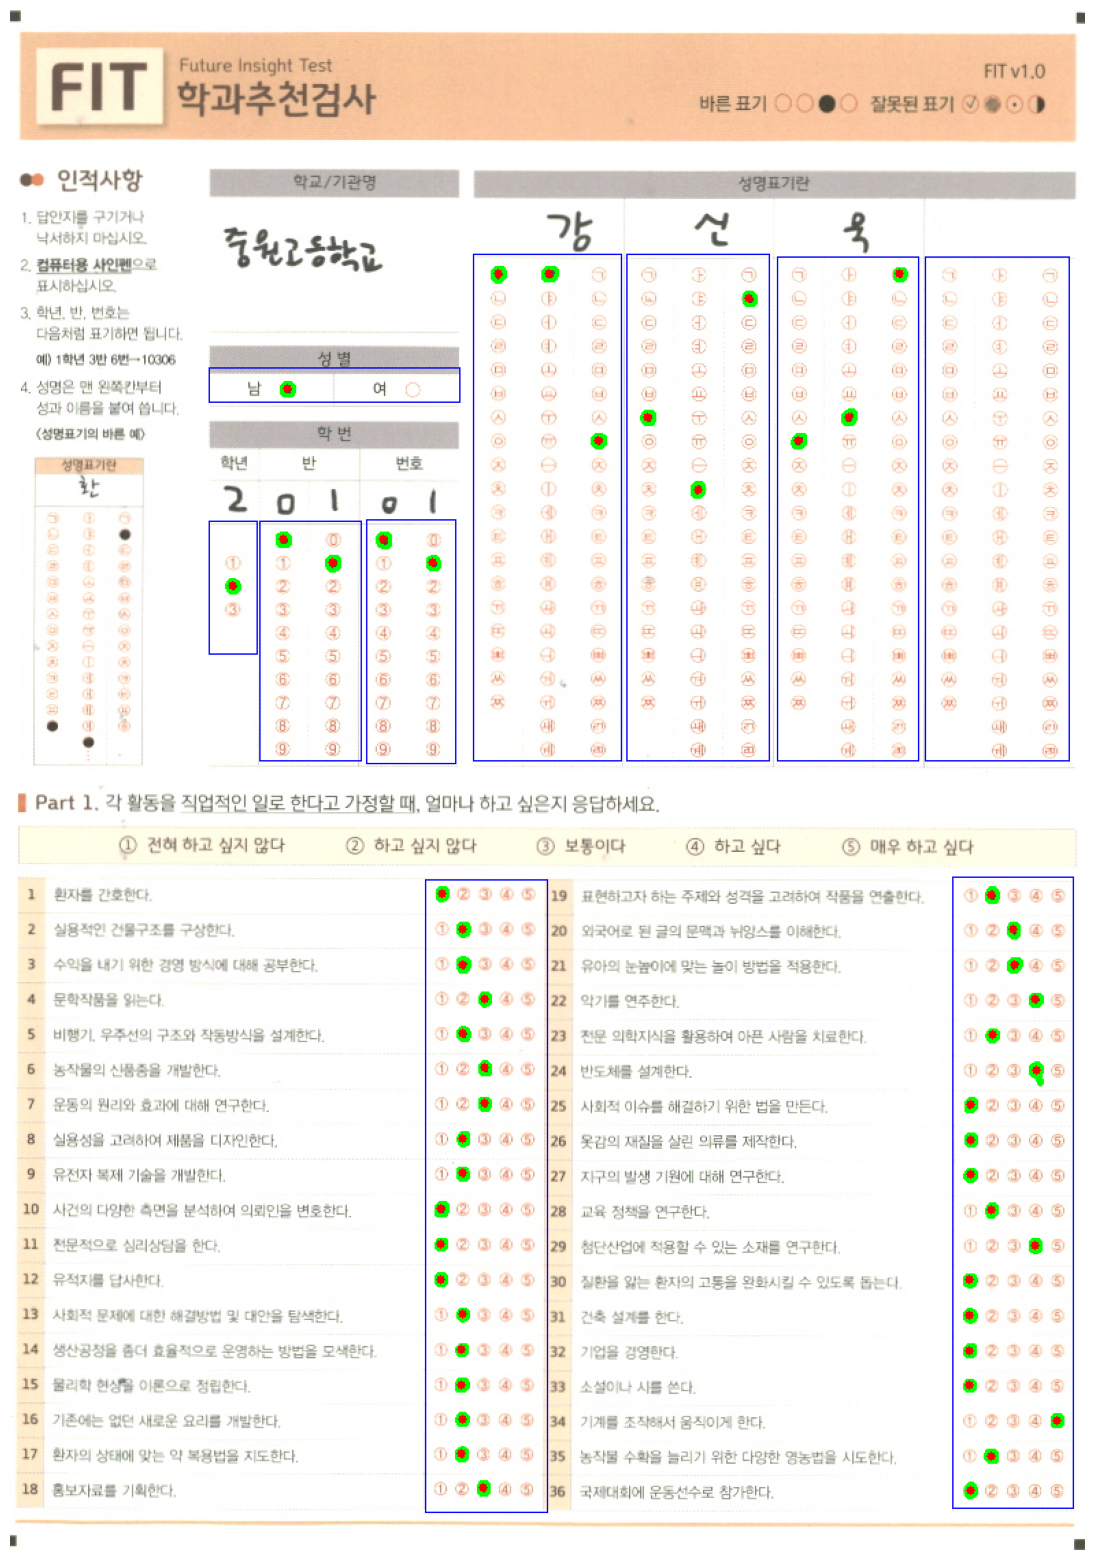

In [861]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def is_in_circle(shifted_cnt, wh_ratio):
    (x, y), radius = cv2.minEnclosingCircle(shifted_cnt)
    radius = int(radius)//2
    
    # 원의 경계 좌표
    circle_left = x - radius
    circle_top = y - radius
    circle_right = x + radius
    circle_bottom = y + radius

    # 원이 사각형 내부에 완전히 포함되는지 확인
    pass_point = False
    for rect_point in wh_ratio:
        left, top, right, bottom = rect_point
        if (circle_left >= left and
            circle_top >= top and
            circle_right <= right and
            circle_bottom <= bottom):
            pass_point = True
            break
    
    if not pass_point:
        return False
    
    return True


filename = 'square_FIT_page_1_right.jpg' # 사용자 정의 네모칸
image = cv2.imread('./scan/datas/FIT/0001.jpg') # 마킹된 실제 검사지
origin_image = cv2.imread(f'./scan/datas/pdf/circles/circles_{filename}') # 노마킹 원본

# 그레이스케일 변환
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# 블러링을 통해 노이즈 제거
blurred = cv2.GaussianBlur(gray, (9, 9), 0)

# 바이너리 스레시홀딩
_, binary = cv2.threshold(blurred, 180, 255, cv2.THRESH_BINARY_INV)

# 외곽선 찾기
contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# 색칠된 동그라미만 남기기 위해 필터링
filtered_contours = [cnt for cnt in contours if (cv2.contourArea(cnt) > 10) and (cv2.contourArea(cnt) < 150)]

rectangles = filtered_contours[:10] + filtered_contours[-10:]
rect_dict = dict()
cut_xy = []

for rdx, rect in enumerate(rectangles):
    x, y, w, h = cv2.boundingRect(rect)
    rect_dict[rdx] = [x, y, w, h]

max_sum = float('-inf')
min_sum = float('inf')

for key, (x, y, w, h) in rect_dict.items():
    if (x < 20) or (y < 20):
        continue
    current_sum = x + y
    if current_sum > max_sum:
        max_sum = current_sum
        max_key = key
    if current_sum < min_sum:
        min_sum = current_sum
        min_key = key
print("x+y가 가장 큰 key:", max_key) # 우하단
print("x+y가 가장 작은 key:", min_key) # 좌상단
x, y = rect_dict[min_key][:2]
xw, yh = rect_dict[max_key][0] + rect_dict[max_key][2], rect_dict[max_key][1] + rect_dict[max_key][3]
image = image[y:yh, x:xw]

height, width = image.shape[:2]
origin_height, origin_width = origin_image.shape[:2]

x_ratio_re = width / origin_width
y_ratio_re = height/ origin_height

wh_ratio = [[int(x * x_ratio_re), int(y * y_ratio_re), int(xw * x_ratio_re), int(yh * y_ratio_re)] 
            for (x, y, xw, yh) in rects_point_dict[filename]]
shifted_contours = []
for cnt in filtered_contours:
    shifted_cnt = np.array(cnt)
    shifted_cnt[:, :, 0] -= x  
    shifted_cnt[:, :, 1] -= y  
    if is_in_circle(shifted_cnt, wh_ratio):
        shifted_contours.append(shifted_cnt)
    
    
# 원본 이미지에 외곽선 그리기
output_image = image.copy()
cv2.drawContours(output_image, shifted_contours, -1, (0, 255, 0), 2)

point_list = []
for cnt in shifted_contours:
    M = cv2.moments(cnt)
    if M["m00"] != 0:
        cX = int(M["m10"] // M["m00"])
        cY = int(M["m01"] // M["m00"])
        cv2.circle(output_image, (cX, cY), 3, (0, 0, 255), -1)  # 중심에 파란색 점 그리기
        point_list.append([cX, cY])

# 결과 이미지 보기
for x,y,xw,yh in wh_ratio:
    start_point = (x,y)
    end_point = (xw,yh)
    color = (255, 0, 0)  # 사각형 색상 (B, G, R) 형식
    thickness = 1  # 사각형 선 두께
    cv2.rectangle(output_image, start_point, end_point, color, thickness)

plt.figure(figsize=(20, 20))
plt.imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

1.9885350318471338 1.9964444444444445
[[701, 1081], [345, 1079], [716, 1056], [329, 1054], [764, 1030], [330, 1029], [700, 1004], [329, 1004], [700, 979], [329, 978], [700, 953], [330, 952], [700, 927], [314, 927], [748, 902], [314, 901], [716, 876], [314, 875], [701, 850], [330, 849], [701, 825], [330, 824], [701, 799], [346, 798], [749, 774], [346, 772], [717, 748], [330, 747], [748, 722], [346, 722], [733, 697], [330, 697], [732, 671], [330, 671], [716, 646], [315, 645], [162, 420], [308, 403], [235, 403], [272, 386], [199, 386], [502, 350], [575, 314], [429, 314], [465, 297], [612, 297], [202, 276], [539, 210], [649, 192], [393, 192], [356, 192]]
[[1393, 2158], [686, 2154], [1423, 2108], [654, 2104], [1519, 2056], [656, 2054], [1391, 2004], [654, 2004], [1391, 1954], [654, 1952], [1391, 1902], [656, 1900], [1391, 1850], [624, 1850], [1487, 1800], [624, 1798], [1423, 1748], [624, 1746], [1393, 1696], [656, 1694], [1393, 1647], [656, 1645], [1393, 1595], [688, 1593], [1489, 1545], [6

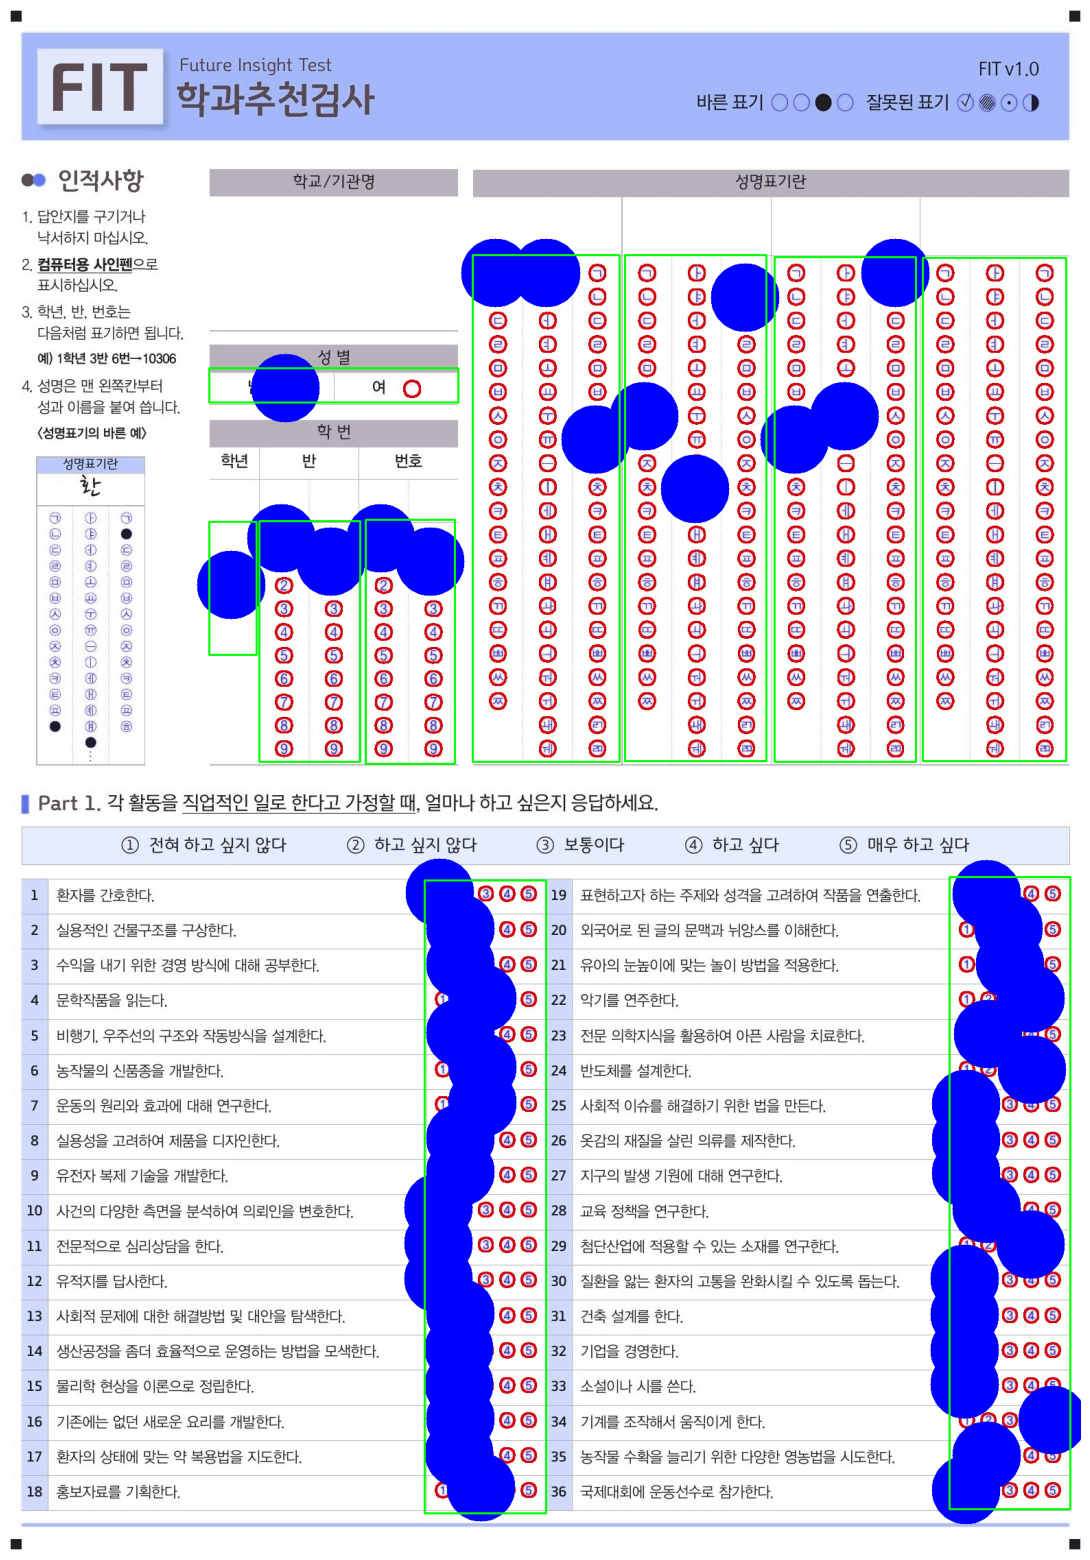

In [872]:
x_ratio = origin_width / width
y_ratio = origin_height/ height
print(x_ratio, y_ratio)

new_points = [[int(x * x_ratio), int(y * y_ratio)] for (x, y) in point_list]
print(point_list)
print(new_points)


for cnt in new_points:
    cv2.circle(origin_image, cnt, 10, (0, 0, 255), -1)  # 중심에 파란색 점 그리기

for x,y,xw,yh in rects_point_dict[filename]:
    start_point = (x,y)
    end_point = (xw,yh)
    color = (0, 255, 0)
    thickness = 2
    cv2.rectangle(origin_image, start_point, end_point, color, thickness)
    
plt.figure(figsize=(20, 20))
plt.imshow(origin_image)
plt.axis('off')
plt.show()